In [71]:
import sys
import os
import pandas as pd
import numpy as np
# sys.path.append('/root/barcode/')
sys.path.append('../')
from BarcodeScanner import tree_and_clustering, base_barcode
from itertools import product, combinations
from sklearn.linear_model import LinearRegression
import timeit


def gen_X(num_var: int, sample_size : int):
    data_dictionary = {}
    for i in range(num_var):
        var_name = "x" + f"{i + 1}"
        data_dictionary[var_name] = list(np.random.binomial(1, .5, sample_size))
    return pd.DataFrame(data_dictionary)

def gen_full_X(num_var: int, sample_size :int):
    raw_X = gen_X(num_var = num_var, sample_size = sample_size)
    colnames = raw_X.columns
    for k in range(2, len(colnames)+ 1):
        interaction_generator = combinations(colnames, k)
        for interaction_tuple in interaction_generator:
            new_colname = "*".join(interaction_tuple)
            raw_X[new_colname] = raw_X[list(interaction_tuple)].apply(np.prod, axis = 1)
    return raw_X

def gen_barcode_frame(num_var:int, sample_size:int):
    raw_X = gen_X(num_var = num_var, sample_size = sample_size)
    raw_colnames = raw_X.columns.tolist()
    raw_X['z'] = base_barcode.gen_barcode(raw_X).reshape(-1)
    raw_X = raw_X.drop(raw_colnames, axis = 1)
    return raw_X


In [72]:
from sys import getsizeof

## Experiment 1: Memory use of design matrix

In [3]:
number_of_variables = [3,4,5,6]
sample_sizes = range(5_000, 50_001, 5_000)
full_design_matrix_size = []
barcode_matrix_size = []
len(sample_sizes)

10

In [4]:
from tqdm import tqdm
for num_var, sample_size in tqdm(product(number_of_variables, sample_sizes), total = 10*4):
    x1 = gen_full_X(num_var, sample_size).to_numpy().astype(np.uint8)
    x2 = gen_barcode_frame(num_var, sample_size).to_numpy()
    full_design_matrix_size.append(x1.nbytes); barcode_matrix_size.append(x2.nbytes)

    

100%|██████████| 40/40 [09:18<00:00, 13.97s/it]


In [5]:
df_full_x = pd.DataFrame( product(number_of_variables, sample_sizes), columns = ['number of variables','number of observations'])
df_full_x['type'] = 'design matrix'
df_barcode = pd.DataFrame( product(number_of_variables, sample_sizes), columns = ['number of variables','number of observations'])
df_barcode['type'] = 'dataframe with bar-code variable'
df_full_x['memory usage'] = full_design_matrix_size[-40:]; df_barcode['memory usage'] = barcode_matrix_size[-40:]

In [6]:
df = pd.concat([df_full_x,df_barcode]).reset_index(drop = True)

In [7]:
import seaborn as sns

In [8]:
import matplotlib.pyplot as plt

In [14]:
df['memory usage'] /= 1024 # conver to kilo-bytes

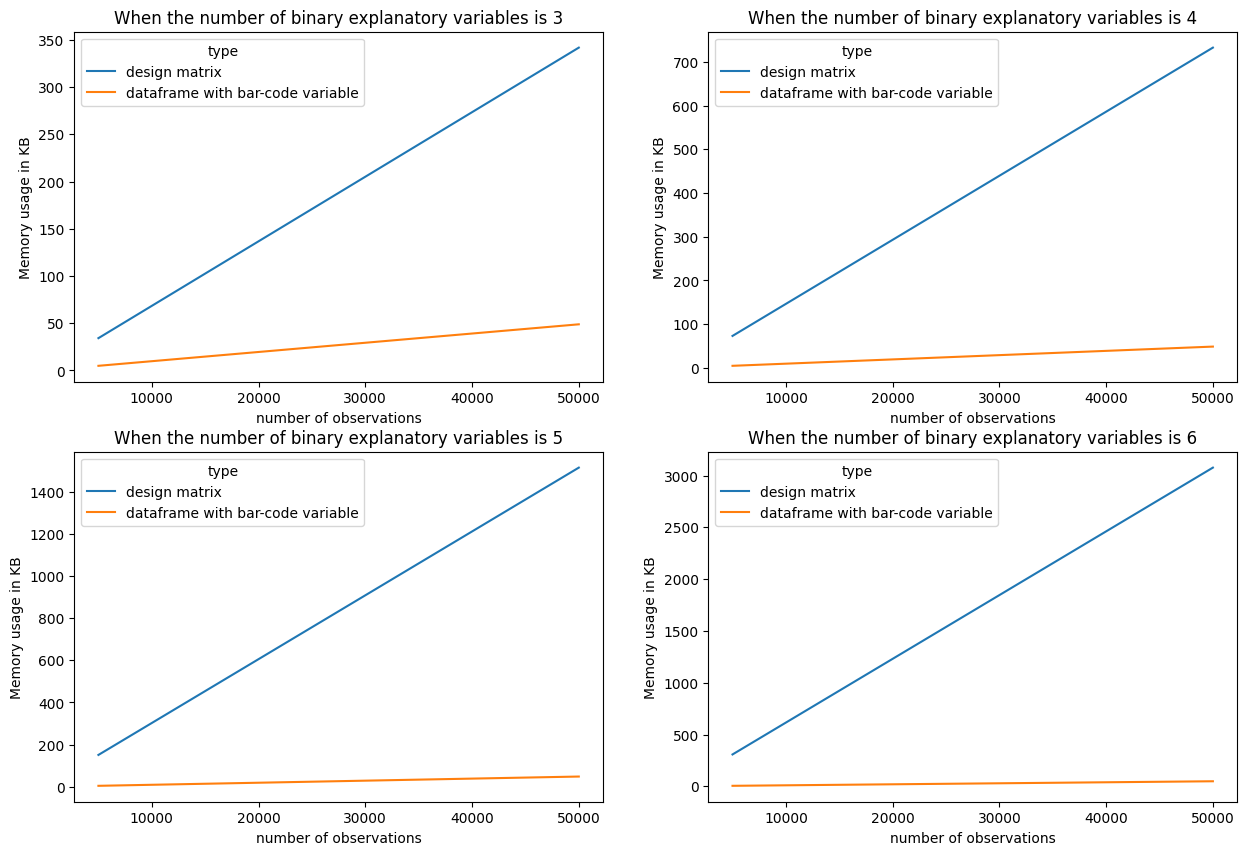

In [17]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10))
for k in range(4):
    if k <2:
        sns.lineplot(data = df.loc[df['number of variables'].eq(k+3),:], x = 'number of observations', y = 'memory usage', hue = 'type', ax = ax[0, k])
        ax[0, k].set_title(f"When the number of binary explanatory variables is {k+3}")
        ax[0, k].set_ylabel("Memory usage in KB")

    else:
        sns.lineplot(data = df.loc[df['number of variables'].eq(k+3),:], x = 'number of observations', y = 'memory usage', hue = 'type', ax = ax[1, k-2])
        ax[1, k-2].set_title(f"When the number of binary explanatory variables is {k+3}")
        ax[1, k-2].set_ylabel("Memory usage in KB")
fig.savefig('memory_simulation_result.png')

# Speed Testing

In [73]:
def gen_full_X(X):
    raw_X = X.copy()
    colnames = raw_X.columns
    for k in range(2, len(colnames)+ 1):
        interaction_generator = combinations(colnames, k)
        for interaction_tuple in interaction_generator:
            new_colname = "*".join(interaction_tuple)
            raw_X[new_colname] = raw_X[list(interaction_tuple)].apply(np.prod, axis = 1)
    return raw_X

def gen_barcode_frame(X):
    raw_X = X.copy()
    raw_colnames = raw_X.columns.tolist()
    raw_X['z'] = base_barcode.gen_barcode(raw_X).reshape(-1)
    raw_X = raw_X.drop(raw_colnames, axis = 1)
    return raw_X


In [74]:
X = gen_X(3, 50_000)
y = np.random.normal(size = 50_000)


In [75]:
df = gen_full_X(X)

In [76]:
timeit.repeat("gen_barcode_frame(X)", globals = globals(), number = 1, repeat = 4)

[0.11030014202697203,
 0.10831978003261611,
 0.11061053501907736,
 0.10827780497493222]

#### Timing datasetups

In [68]:
number_of_variables = [3,4,5,6]
sample_sizes = range(5_000, 50_001, 5_000)
barcode_data_setup_times = []
full_model_data_setup_times = []


In [69]:
from tqdm import tqdm

In [39]:
for num_var, n in tqdm(product(number_of_variables, sample_sizes), total = 40):
    X = gen_X(num_var, n)
    barcode_data_setup_times.append(timeit.repeat("gen_barcode_frame(X)", globals = globals(), number = 1, repeat = 100))
    full_model_data_setup_times.append(timeit.repeat("gen_full_X(X)", globals = globals(), number = 1, repeat = 100))

100%|██████████| 40/40 [10:45:27<00:00, 968.19s/it]  


In [123]:
model_fit_barcode_times = []
model_fit_full_model_times = []

In [60]:
reg = LinearRegression()

In [124]:
from tqdm import tqdm
for num_var, n in tqdm(product(number_of_variables, sample_sizes), total = 40):
    X = gen_X(num_var, n)
    y = np.random.random(size = n).reshape(-1,1)
    anova = anova_clustering(X, y)
    anova.L_inv
    model_fit_barcode_times.append(timeit.repeat("anova.init_beta_hat", globals = globals(), number = 1, repeat = 100))
    X_gen = gen_full_X(X)
    reg = LinearRegression()
    model_fit_full_model_times.append(timeit.repeat("reg.fit(X_gen, y)", globals = globals(), number = 1, repeat = 100))


100%|██████████| 40/40 [10:23<00:00, 15.60s/it]


In [47]:
df = pd.DataFrame(product(number_of_variables, sample_sizes), columns = ['number of variables','sample size'])

In [151]:
df['barcode_data_time_mean'] = [np.mean(x) for x in barcode_data_setup_times]
df['linear_data_time_mean'] = [np.mean(x) for x in full_model_data_setup_times]
df['barcode_model_fit_time_mean'] = [np.mean(x) for x in model_fit_barcode_times]
df['linear_model_fit_time_mean'] = [np.mean(x) for x in model_fit_full_model_times]

df.head()



,barcode_data_time_mean,barcode_model_fit_time_mean,linear_data_time_mean,linear_model_fit_time_mean
"(3, 5000)",0.017460,1.033234e-06,0.287489,0.001302
"(3, 10000)",0.034196,7.105916e-07,0.576951,0.001797
"(3, 15000)",0.051454,7.612386e-07,0.859148,0.002729
"(3, 20000)",0.067730,7.317803e-07,1.144353,0.003518
"(3, 25000)",0.084394,7.377012e-07,1.452326,0.002923


In [156]:
df.to_csv('chapter_1_simulation_result.csv', index = False)

In [157]:
df = pd.read_csv('chapter_1_simulation_result.csv')

In [158]:
df

,number of variables,sample size,methods,mean run-time
0,3,5000,barcode_data_time_mean,0.017460
1,3,5000,barcode_model_fit_time_mean,0.000001
2,3,5000,linear_data_time_mean,0.287489
3,3,5000,linear_model_fit_time_mean,0.001302
4,3,10000,barcode_data_time_mean,0.034196
...,...,...,...,...
155,6,45000,linear_model_fit_time_mean,0.086196
156,6,50000,barcode_data_time_mean,0.169098
157,6,50000,barcode_model_fit_time_mean,0.000001
158,6,50000,linear_data_time_mean,40.383592


In [159]:

import seaborn as sns
import matplotlib.pyplot as plt

In [160]:
df.methods.replace({"linear_data_time_mean":"creating all interactions"}, inplace = True)
df.methods.replace({"barcode_data_time_mean":"bar-code variable"}, inplace = True)
df.methods.replace({"barcode_model_fit_time_mean":"cell means model with bar-code"}, inplace = True)
df.methods.replace({"linear_model_fit_time_mean":"linear regression model with all interaction effects"}, inplace = True)

In [161]:
df

,number of variables,sample size,methods,mean run-time
0,3,5000,bar-code variable,0.017460
1,3,5000,cell means model with bar-code,0.000001
2,3,5000,creating all interactions,0.287489
3,3,5000,linear regression model with all interaction e...,0.001302
4,3,10000,bar-code variable,0.034196
...,...,...,...,...
155,6,45000,linear regression model with all interaction e...,0.086196
156,6,50000,bar-code variable,0.169098
157,6,50000,cell means model with bar-code,0.000001
158,6,50000,creating all interactions,40.383592


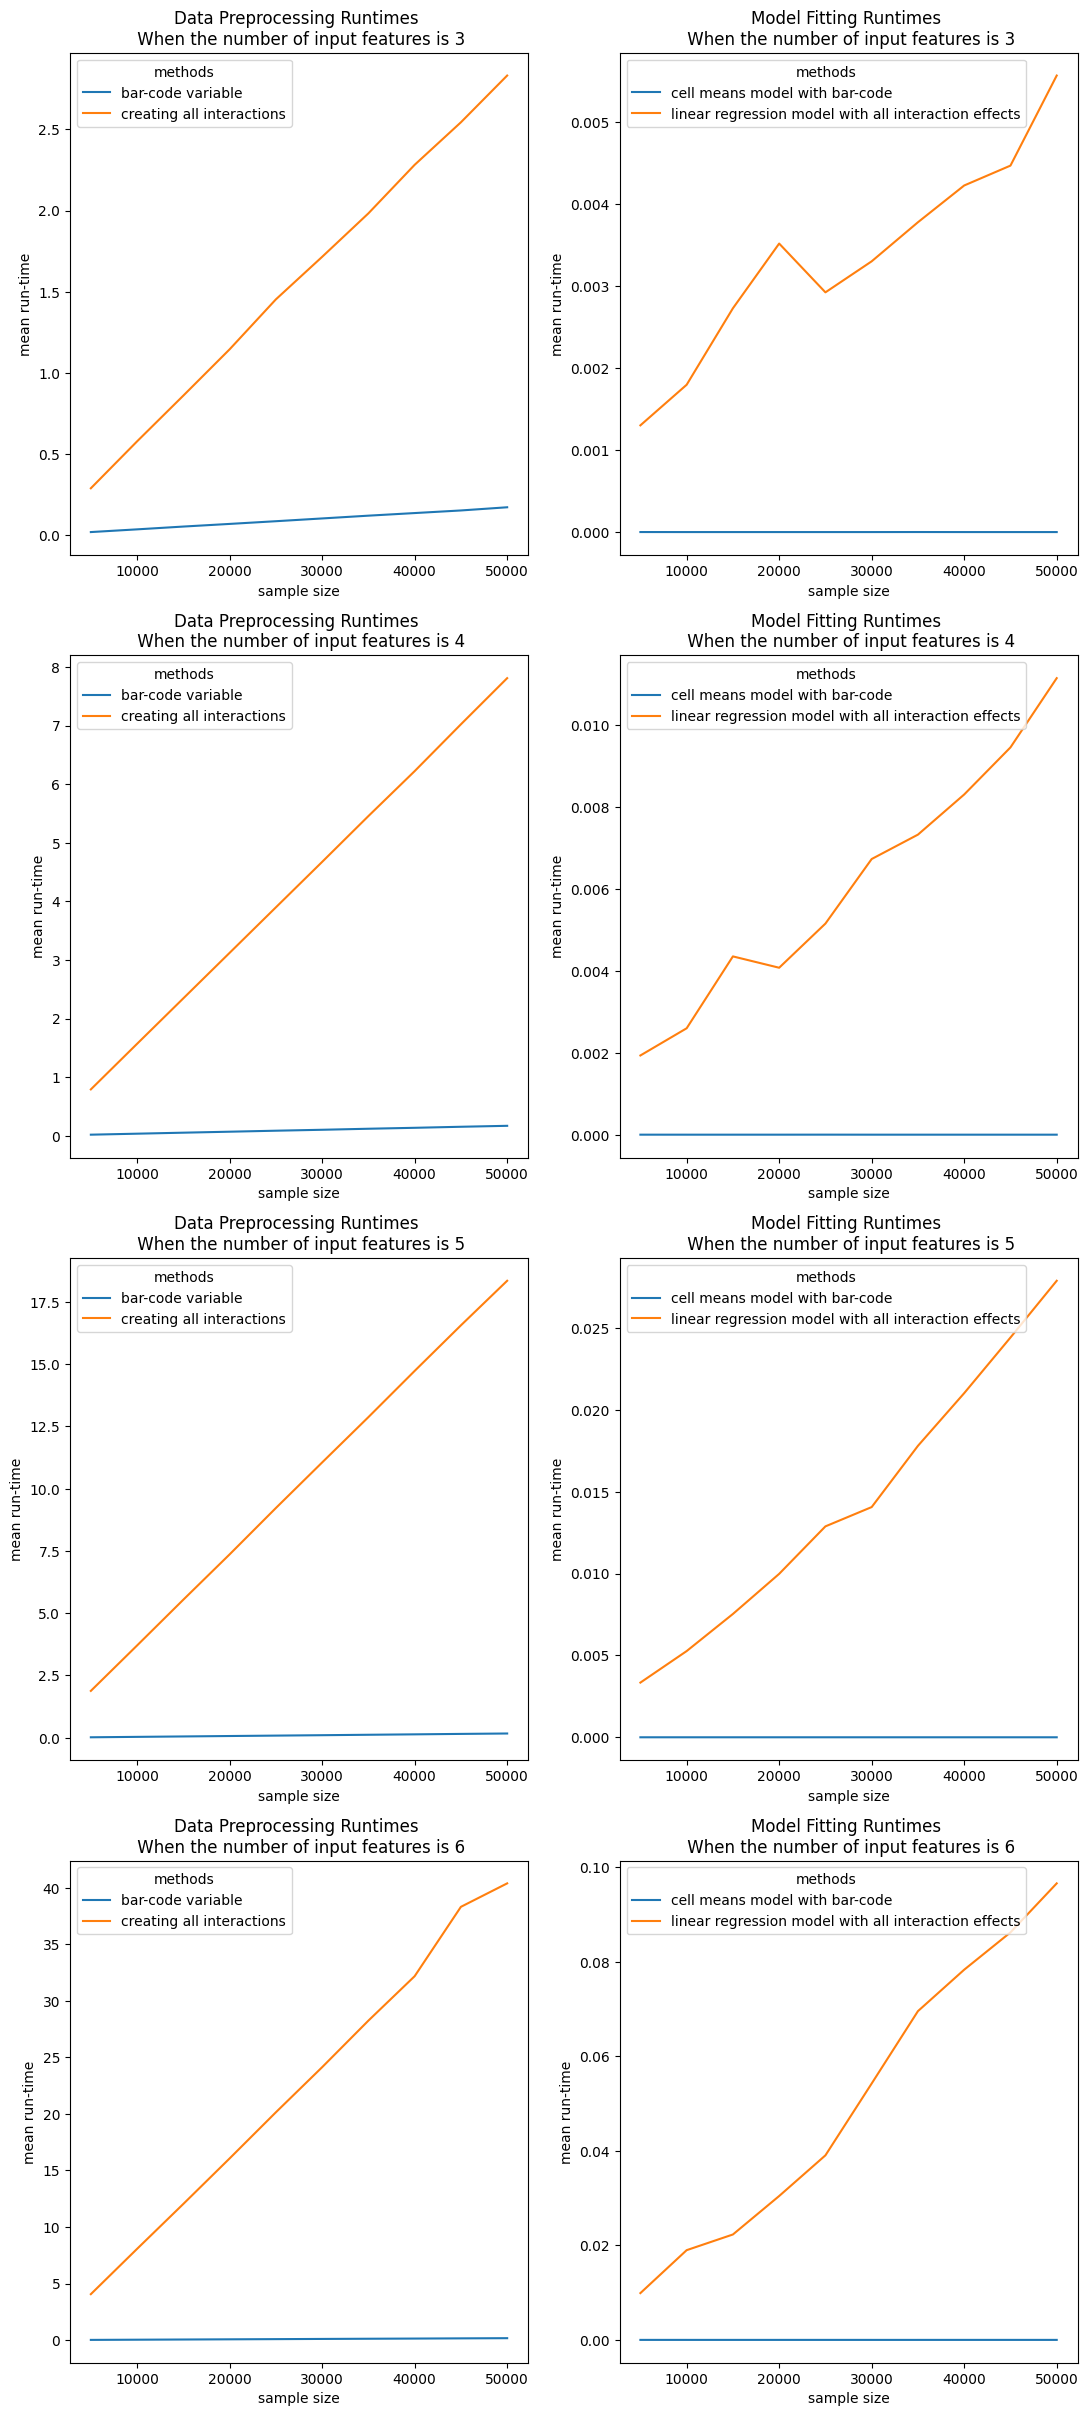

In [162]:
fig, ax = plt.subplots(4, 2, figsize = (13, 30))
for k in range(3, 7):
    sub_df = df.loc[df['number of variables'].eq(k),:]
    sub_df_data_time = sub_df.loc[sub_df['methods'].isin(['creating all interactions','bar-code variable']),:]
    sub_df_model_fit_time = sub_df.loc[sub_df['methods'].isin(['cell means model with bar-code',
                                                               'linear regression model with all interaction effects']),:]
    sns.lineplot(sub_df_data_time, x = 'sample size', y = 'mean run-time', hue = 'methods', ax = ax[k-3, 0])
    sns.lineplot(sub_df_model_fit_time, x = 'sample size', y = 'mean run-time', hue = 'methods', ax = ax[k-3, 1])
    ax[k-3, 0].set_title(f"Data Preprocessing Runtimes \n When the number of input features is {k}")
    ax[k-3, 1].set_title(f"Model Fitting Runtimes \n When the number of input features is {k}")

fig.savefig('runtime_output.png')

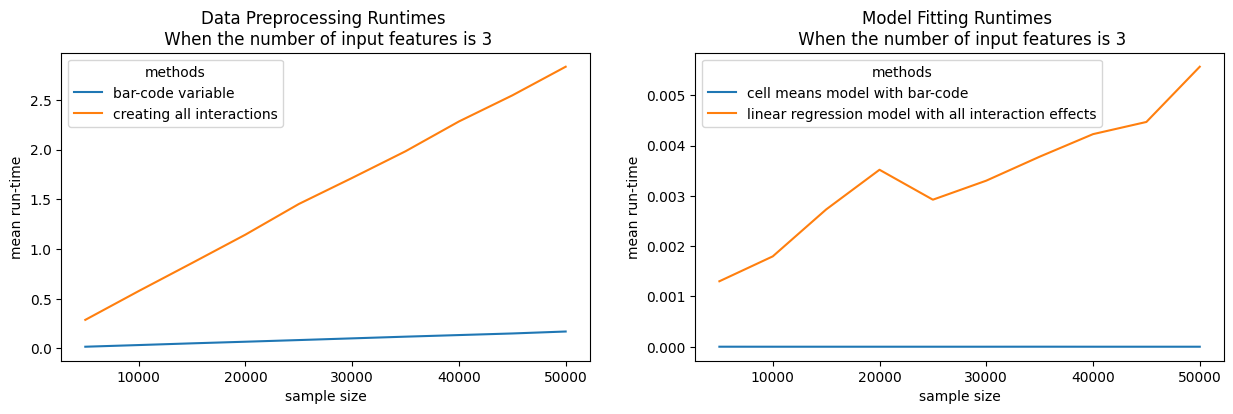

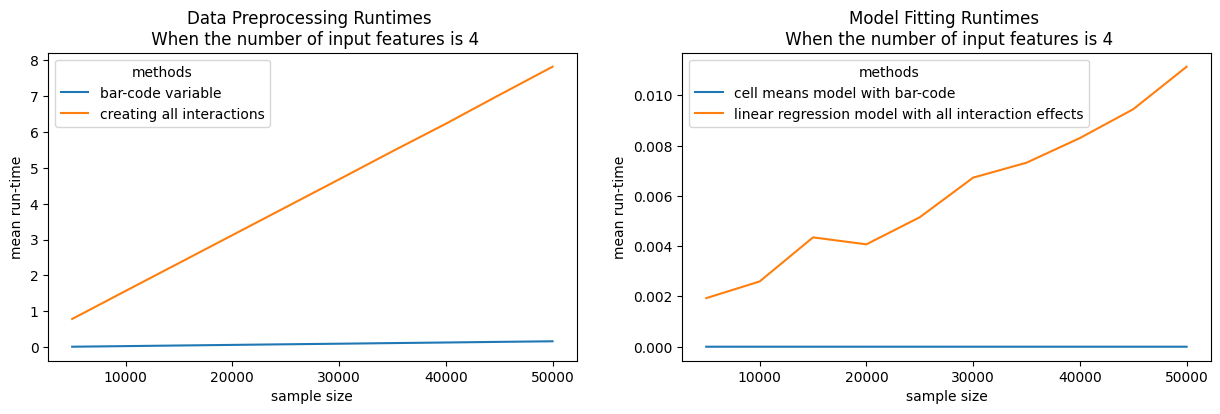

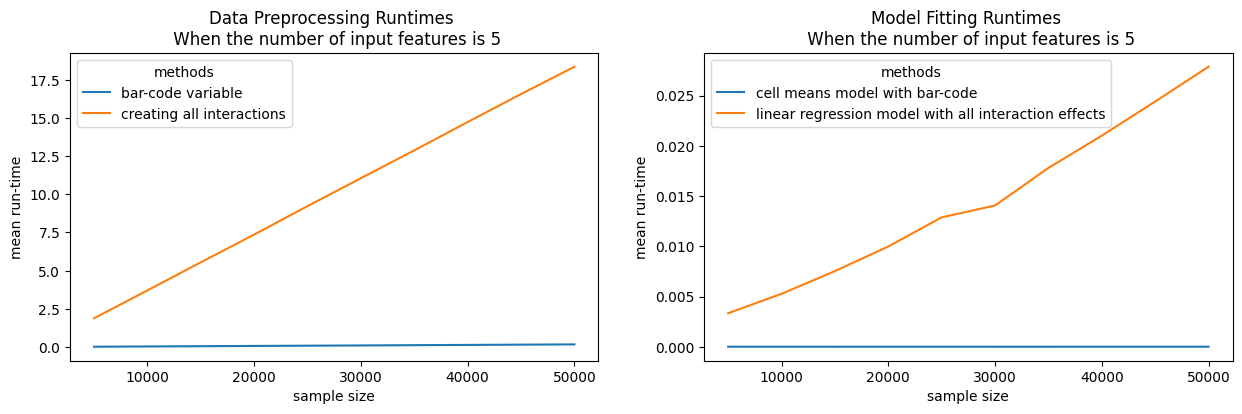

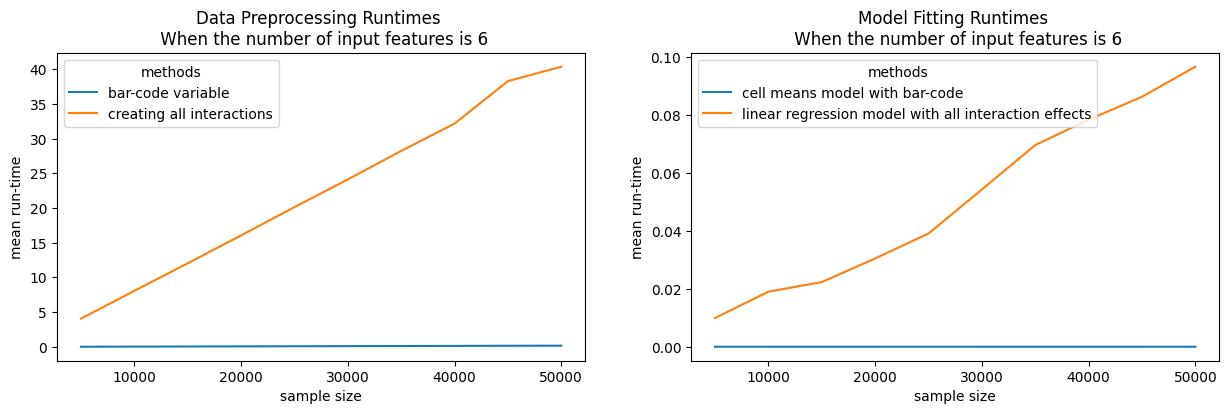

In [163]:
for k in range(3, 7):
    fig, ax = plt.subplots(1, 2, figsize = (15, 4))

    sub_df = df.loc[df['number of variables'].eq(k),:]
    sub_df_data_time = sub_df.loc[sub_df['methods'].isin(['creating all interactions','bar-code variable']),:]
    sub_df_model_fit_time = sub_df.loc[sub_df['methods'].isin(['cell means model with bar-code',
                                                               'linear regression model with all interaction effects']),:]
    sns.lineplot(sub_df_data_time, x = 'sample size', y = 'mean run-time', hue = 'methods', ax = ax[0])
    sns.lineplot(sub_df_model_fit_time, x = 'sample size', y = 'mean run-time', hue = 'methods', ax = ax[1])
    ax[0].set_title(f"Data Preprocessing Runtimes \n When the number of input features is {k}")
    ax[1].set_title(f"Model Fitting Runtimes \n When the number of input features is {k}")

    fig.savefig(f"runtime_output_p_{k}.png")

# fig.savefig('runtime_output.png')

In [58]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

sys.path.append('../importance_score/')
sys.path.append('../permutation_score/')

from interaction_permutation_importance import *
import matplotlib.pyplot as plt

def gen_X(num_var: int, sample_size : int):
    data_dictionary = {}
    for i in range(num_var):
        var_name = "x" + f"{i + 1}"
        data_dictionary[var_name] = list(np.random.binomial(1, .5, sample_size))
    return pd.DataFrame(data_dictionary)

sys.path.append('/root/barcode/')
from BarcodeScanner import tree_and_clustering, base_barcode
from importance_score import f_test_result
import scipy
from scipy.stats import f
from sklearn.base import BaseEstimator, clone
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics      import r2_score

import numpy as np; import pandas as pd
from typing import List, Union

# itertools
from itertools import combinations

from utils import *

class one_way_ANOVA(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, df, response_var_name =None):
        if response_var_name:
            try:
                df[response_var_name]
                self.response_var_name = response_var_name
            except:
                self.response_var_name = df.columns.tolist()[-1]
        else:
            self.response_var_name = df.columns.tolist()[-1]
        self.independet_var_name = df.columns[~df.columns.str.contains(self.response_var_name)].tolist()
        self.segment_means = df.groupby(self.independet_var_name)[self.response_var_name].mean().reset_index()
        self.segment_means.columns= self.segment_means.columns.tolist()[:-1] + ['y_hat']
        output = df.merge(self.segment_means, how = 'left', on = self.independet_var_name)
        y = output[self.response_var_name].to_numpy().reshape(-1)
        y_pred = output['y_hat'].to_numpy().reshape(-1)
        self._rsq = r2_score(y, y_pred)
        self.sse  = np.square(y - y_pred).sum()
        self.MSE_ = self.sse/(y.shape[0])
        output['sq'] = (output.y_hat - output[self.response_var_name])**2
        summary = output.groupby(self.independet_var_name).agg({"y_hat": np.mean, "sq": [lambda x: x.sum()/x.count(), 'count']}).reset_index()
        summary.columns = self.independet_var_name + ['group_means','mse','count']
        self._summary_table = summary
        return self
    

    @property
    def score(self):
        if hasattr(self, '_rsq'):
            return self._rsq
        else:
            raise AttributeError("fit the estimator first")
    
    @property
    def MSE(self):
        if hasattr(self, "MSE_"):
            return self.MSE_
        else:
            raise AttributeError("fit the estimator first")
class anova_clustering(base_barcode):
    def __init__(self, X, y):
        super().__init__(X, y)
        self.clean_data()
        self.estimator = one_way_ANOVA()
        self.fit()

    def clean_data(self):
        full_df = self.X.copy()
        full_df['y'] = self.y.reshape(-1)
        sorted_index = full_df.sort_values(full_df.columns.tolist()[:-1]).index.tolist()
        self.full_df = full_df.loc[sorted_index, :].reset_index(drop = True)
        self.barcode_df = pd.DataFrame(zip(self.barcode.reshape(-1), self.y.reshape(-1)), columns = ['z','y']).loc[sorted_index, :].reset_index(drop = True)
        self.X = full_df.iloc[:, :-1]
        self.y = full_df.y.to_numpy().reshape(-1,1);
        self.num_full_var = 2**self.X.shape[1]
        self.num_main_var = self.X.shape[1]
        del sorted_index
        del full_df
        
    def fit(self):   
        self.estimator.fit(self.full_df)
        self._summary_table = self.estimator._summary_table
        self._fit = True

    def gen_clustering_summary_table(self, num_clusters):
        original_summary = self.summary_table.copy()
        original_summary = original_summary.drop(['group_means','mse', 'count'], axis = 1)
        original_summary['y_pred'] = self.get_projected_mu_hat(num_clusters)
        full_df = self.full_df.copy()
        full_df = full_df.merge(original_summary, on = self.estimator.independet_var_name, how = 'left')
        return full_df
    
    def metric_after_clustering(self, num_clusters, metric = r2_score):
        full_df = self.gen_clustering_summary_table(num_clusters)
        return metric(full_df.y, full_df.y_pred)



    @property
    def summary_table(self):
        if hasattr(self, "_summary_table"):
            pass
        else:
            self._summary_table = self.predict_from_training()
        return self._summary_table
    
    @property
    def init_mu_hat(self):
        if hasattr(self, "_init_mu_hat"):
            pass
        else:
            self._init_mu_hat = self.summary_table.group_means.tolist()
            self._init_mu_hat = np.array(self._init_mu_hat).reshape(-1)
        return self._init_mu_hat
    
    @property
    def init_mu_var(self):
        if hasattr(self, "_init_mu_var"):
            pass
        else:
            self._init_mu_var = np.diag(self.summary_table.mse/self.summary_table['count'])
        return self._init_mu_var
    
    @property
    def init_beta_hat(self):
        if hasattr(self, "_init_beta_hat"):
            pass
        else:
            self._init_beta_hat = self.L_inv @ self.init_mu_hat
        return self._init_beta_hat

    @property
    def init_beta_var(self):
        if hasattr(self, "_init_beta_var"):
            pass
        else:
            self._init_beta_var = self.L_inv @ self.init_mu_var @ self.L_inv.T
        return self._init_beta_var

    @property
    def clustering_init_kwargs(self):
        summary = self.summary_table
        kwargs = {"means": summary.group_means.tolist(), "variances": summary.mse.tolist(), "sample_sizes": summary['count'].tolist()}
        return kwargs
    
    @property
    def init_cluster_idx(self):
        if hasattr(self, "_init_cluster_idx"):
            pass
        else:
            sample_sizes = self.clustering_init_kwargs['sample_sizes']
            clusters = []
            last = 0
            for n in sample_sizes:
                clusters.append([x for x in range(last, n+last)])
                last += n
            self._init_cluster_idx = clusters
        return self._init_cluster_idx

    @property
    def init_pdist(self):
        if hasattr(self, "_init_pdist"):
            pass
        else:
            self._init_pdist = self.pairwise_distances_from_means_variances(**self.clustering_init_kwargs)
        return self._init_pdist

    def cluster(self, n_clusters, save = True):
        self.last_n_clusters = n_clusters
        pdist = self.init_pdist.copy()
        init_cluster_idx = self.init_cluster_idx.copy()
        result = self.agglomerative_clustering(pairwise_distances = pdist, n_clusters = n_clusters, clusters = init_cluster_idx)
        cluster_idx = result[0]
        final_pdist = result[1]
        cluster_df = {}
        for cluster_id, cluster_index in enumerate(cluster_idx):
            cluster_id_name = f"cluster_{cluster_id}"
            cluster_df[cluster_id_name] = self.full_df.loc[cluster_index,:].copy()
            cluster_df[cluster_id_name] = cluster_df[cluster_id_name].groupby(self.original_columns).agg(np.mean).reset_index()
            cluster_df[cluster_id_name]['barcode'] = self.gen_barcode((cluster_df[cluster_id_name].loc[:, self.original_columns]))
        if save:
            self._latest_cluster_dfs = cluster_df
        else:
            self._latest_cluster_dfs = None
        
        return {"cluster": cluster_df, "final_pdist": final_pdist}

    def gen_mu_contrast_from_cluster(self, n_clusters, use_latest_cluster_df = True):
        if use_latest_cluster_df:
            if hasattr(self, '_latest_cluster_dfs'):
                if (self._latest_cluster_dfs != None) & (self.last_n_clusters == n_clusters):
                    cluster_df_list = self._latest_cluster_dfs
        try:
            cluster_df_list
        except:
            cluster_result = self.cluster(n_clusters = n_clusters)
            cluster_df_list = cluster_result['cluster']
            
        contrast_matrix = 0
        for cluster_name, cluster_df in cluster_df_list.items():
            if cluster_df.shape[0] > 1:
                contrast = np.zeros((cluster_df.shape[0]-1, 2**len(self.original_columns)))
                for i, row in enumerate(contrast):
                    row[cluster_df.barcode[0]] = 1
                    row[cluster_df.barcode[i+1]] = -1
                    contrast[i] = row
                if isinstance(contrast_matrix, np.ndarray):
                    contrast_matrix = np.concatenate([contrast_matrix, contrast], axis = 0)
                else:
                    contrast_matrix = contrast
            else:
                pass
        return contrast_matrix
    
    def gen_projection_matrix_mu(self, n_clusters):
        C = self.gen_mu_contrast_from_cluster(n_clusters)
        projection_matrix = C.T @ np.linalg.inv(C @ C.T) @ C
        projection_matrix = np.identity(C.shape[1]) - projection_matrix
        return projection_matrix
    
    def get_projected_mu_hat(self, n_clusters):
        mu = self.init_mu_hat
        proj_mu = self.gen_projection_matrix_mu(n_clusters = n_clusters) @ mu
        return proj_mu
    
    def get_projected_mu_hat_var(self, n_clusters):
        mu_var = self.init_mu_var
        proj = self.gen_projection_matrix_mu(n_clusters = n_clusters)
        proj_mu_var = proj @ mu_var @ proj.T
        return proj_mu_var
    
    def get_projected_beta_hat(self, n_clusters):
        proj_mu = self.get_projected_mu_hat(n_clusters = n_clusters)
        proj_beta = self.L_inv @ proj_mu
        return proj_beta
    
    def get_projected_beta_hat_var(self, n_clusters):
        mu_var = self.get_projected_mu_hat_var(n_clusters)
        return self.L_inv @ mu_var @ self.L_inv.T

    
    def ward_linkage(self, pairwise_distances, clusters, merge_indices):
        clusters = clusters.copy()
        i, j = merge_indices
        cluster_i = clusters[i]
        cluster_j = clusters[j]
        n_i = len(cluster_i)
        n_j = len(cluster_j)
        n = pairwise_distances.shape[1]
        new_distances = pairwise_distances.copy()
        new_distances = np.delete(new_distances, merge_indices, axis = 0)
        new_distances = np.delete(new_distances, merge_indices, axis = 1)
        new_distances = np.append(new_distances, np.zeros((1, new_distances.shape[1])), axis = 0)
        new_distances = np.append(new_distances,  np.zeros((new_distances.shape[0], 1)), axis = 1)
        clusters.append(cluster_i + cluster_j)
        clusters.remove(cluster_i)
        clusters.remove(cluster_j)
        col = 0
        
        for k in range(n):  # Subtract 2 because we've already added a row and column
            if k != i and k != j:
                n_k = len(clusters[col])
                n_all = n_i + n_j + n_k
                dist_ik = pairwise_distances[i, k]*(n_k + n_i)/n_all
                dist_jk = pairwise_distances[j, k]*(n_j + n_k)/n_all
                dist_ij = pairwise_distances[i, j]*(n_k)/n_all
                new_dist = dist_ik + dist_jk - dist_ij
                # Add other linkage methods here if needed
                
                new_distances[-1, col] = new_dist
                new_distances[col, -1] = new_dist
                col += 1

        return new_distances, clusters
    
    def gen_reduced_clustering(self, n_clusters):
        return self.agglomerative_clustering(pairwise_distances= self.init_pdist, n_clusters = n_clusters)

    def agglomerative_clustering(self, pairwise_distances, n_clusters, clusters = None, estimator = None):
        n = pairwise_distances.shape[0]
        if clusters:
            pass
        else:
            clusters = [[i] for i in range(n)]
        
        assert len(clusters) == n
        
        for k in range(n - n_clusters):
            min_dist = np.inf
            merge_indices = None
            
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    dist = pairwise_distances[i, j]
                    if dist < min_dist:
                        min_dist = dist
                        merge_indices = (i, j)
            
            if merge_indices:
                pairwise_distances, clusters = self.ward_linkage(pairwise_distances, clusters, merge_indices)
        
        return clusters, pairwise_distances
    
    def pairwise_distances_from_means_variances(self, means, variances, sample_sizes):
        num_clusters = len(means)
        pairwise_distances = np.zeros((num_clusters, num_clusters))
        
        for i in range(num_clusters):
            for j in range(i + 1, num_clusters):
                n_i = sample_sizes[i]
                n_j = sample_sizes[j]
                mean_i = means[i]
                mean_j = means[j]
                var_i = variances[i]
                var_j = variances[j]
                
                # Calculate the pairwise distance using Ward linkage formula
                numerator = (n_i * n_j / (n_i + n_j)) * (mean_i - mean_j)**2
                denominator = np.sqrt((n_i * var_i + n_j * var_j) / (n_i + n_j))
                
                pairwise_distances[i, j] = np.sqrt(numerator / denominator)
                pairwise_distances[j, i] = pairwise_distances[i, j]
        
        return pairwise_distances

    def contrast_generator(self, max_variables = None):
        from itertools import product
        from scipy.sparse import vstack
        all_interaction_betas = scipy.sparse.eye(self.num_full_var - self.num_main_var -1, self.num_full_var, k = self.num_main_var + 1)
        betas_in_test = product([False, True], repeat = self.num_full_var - self.num_main_var -1)
        
        def get_new_contrasts(beta):
            vstacks = []
            for i, b in enumerate(beta):
                if b:
                    vstacks.append(all_interaction_betas.getrow(i))
            return vstack(vstacks).astype(np.uint8)
        if max_variables is not None:
            for beta in betas_in_test:
                if sum(beta) and (sum(beta) <= max_variables):
                    yield get_new_contrasts(beta)
        else:
            for beta in betas_in_test:
                if sum(beta):
                    yield get_new_contrasts(beta)


    @staticmethod    
    def partial_f_test(contrast, L_inv, cell_means, cell_means_covariance, sample_size):
        assert contrast.shape[0] < contrast.shape[1]
        assert contrast.shape[1] == L_inv.shape[0]
        assert L_inv.shape[0] == L_inv.shape[1]
        assert cell_means_covariance.shape == L_inv.shape
        from numpy.linalg import inv
        nu_1 = contrast.shape[0]
        nu_2 = sample_size - L_inv.shape[0]
        contrast = contrast.toarray()

        LC = contrast @ L_inv.T
        mu = LC @ cell_means
        var = LC @ cell_means_covariance @ LC.T
        try:
            f_value = mu.T @ inv(var) @ mu
            f_value /= nu_1
        except:
            f_value = 0
        
        return f_test_result(nu_1, nu_2, f_value)
    
    def gen_importance_score(self, num_clusters, filename = 'importance_score.csv', dir = os.getcwd(), max_variables = None):
        cell_means = self.get_projected_mu_hat(num_clusters)
        covariance = self.get_projected_mu_hat_var(num_clusters)
        kwargs = {"L_inv": self.L_inv, "cell_means": cell_means, "cell_means_covariance": covariance, "sample_size": self.X.shape[0]}

        from csv import writer
        from tqdm import tqdm
        with open(os.path.join(dir, filename), 'w') as f:
            csv_writer = writer(f)
            csv_writer.writerow(self.beta_names + ['score'])
            contrasts =  self.contrast_generator(max_variables = max_variables)
            from math import comb
            if max_variables:
                total_iter = sum([comb(self.num_full_var - self.num_main_var -1, x) for x in range(1, max_variables +1)])
            else:
                total_iter = sum([comb(self.num_full_var - self.num_main_var -1, x) for x in range(1,self.num_full_var - self.num_main_var)])
            for contrast in tqdm(contrasts, total = total_iter):
                result = self.partial_f_test(contrast = contrast, **kwargs)
                score = result.cdf
                row = contrast.sum(axis = 0).tolist()[0] + [score]
                csv_writer.writerow(row)
            else:
                from joblib import Parallel, delayed
                num_cores = os.cpu_count()
                batch_size = 1000 * num_cores
                partition_size = 1000
                contrast_batch = []
                for i, contrast in tqdm(enumerate(contrasts), total = total_iter):
                    contrast_batch.append(contrast)
                    if len(contrast_batch) % batch_size == 0:
                        f_test_results = Parallel(n_jobs=num_cores)(delayed(self.partial_f_test)(c, **kwargs) for c in contrast_batch)
                        f_test_results = [x.cdf for x in f_test_results]
                        rows = [c.sum(axis = 0).tolist()[0] + [f] for c,f in zip(contrast_batch, f_test_results)]
                        csv_writer.writerows(rows)
                        del contrast_batch
                        del rows
                        del f_test_results
                        contrast_batch = []
                # process the remainder
                if len(contrast_batch):
                    f_test_results = Parallel(n_jobs=num_cores)(delayed(self.partial_f_test)(c, **kwargs) for c in contrast_batch)
                    f_test_results = [x.cdf for x in f_test_results]
                    rows = [c.sum(axis = 0).tolist()[0] + [f] for c,f in zip(contrast_batch, f_test_results)]
                    csv_writer.writerows(rows)

from glob import glob
import pandas as pd
from dask import dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import joblib
@dataclass
class f_test_result:
    nu_1:int
    nu_2:int
    f_statistic: float
    
    @property
    def p_value(self):
        if hasattr(self, '_p_value'):
            pass
        else:
            sdf = f.sf(self.f_statistic, self.nu_1, self.nu_2, loc=0, scale=1)
            self._p_value = sdf
        return self._p_value
    
    @property
    def cdf(self):
        if hasattr(self, '_cdf'):
            pass
        else:
            self._cdf = 1 - self.p_value
        return self._cdf
from math import sqrt
def gen_y(seq):
    y = 1 + seq.x1 + seq.x2+ seq.x3 + seq.x4 + seq.x5 + seq.x1*(seq.x3 + seq.x4 + seq.x3*seq.x4 + seq.x2*seq.x3*seq.x4) + seq.x2*(seq.x4 + seq.x3*seq.x4 + seq.x3*seq.x4*seq.x5) + seq.x3*(seq.x4 + seq.x4 * seq.x5) + seq.x4*seq.x5
    y += np.random.normal(scale = sqrt(2))
    return y